Downloading necessary libraries

In [1]:
pip install PyWavelets==0.5.2

     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: PyWavelets
    Found existing installation: PyWavelets 1.2.0
    Uninstalling PyWavelets-1.2.0:
      Successfully uninstalled PyWavelets-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.18.3 requires PyWavelets>=1.1.1, but you have pywavelets 0.5.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
pip install opencv-python==3.4.3.18

     |████████████████████████████████| 25.0 MB 1.4 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it

We will use haar cascade from opencv for this.

In [26]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
main_path = '/content/drive/MyDrive/Colab Notebooks/projects/'

In [28]:
img = cv2.imread(main_path + 'test_images/shakib1.jpg')
img.shape

(350, 350, 3)

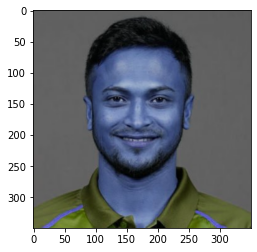

In [29]:
plt.imshow(img)

In [30]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(350, 350)

In [31]:
gray

array([[96, 96, 96, ..., 92, 92, 92],
       [96, 96, 96, ..., 92, 92, 92],
       [96, 96, 96, ..., 92, 92, 92],
       ...,
       [97, 95, 95, ..., 96, 82, 71],
       [98, 96, 95, ..., 90, 69, 56],
       [99, 95, 95, ..., 84, 59, 46]], dtype=uint8)

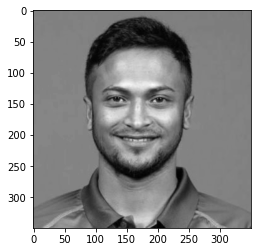

In [32]:
plt.imshow(gray, cmap='gray')

In [33]:
face_cascade = cv2.CascadeClassifier(main_path + 'opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(main_path + 'opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 76,  73, 183, 183]], dtype=int32)

In [34]:
(x,y,w,h) = faces[0]
x,y,w,h

(76, 73, 183, 183)

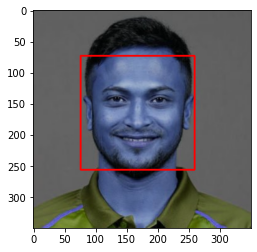

In [35]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

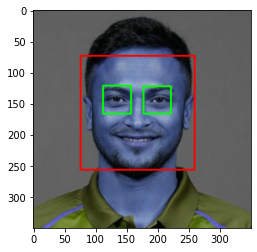

In [36]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

###Cropping the facial region with two eyes and face detected by opencv haarcascade

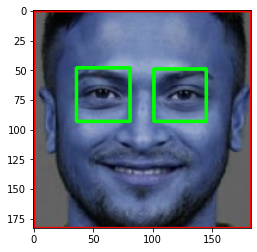

In [37]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [38]:
cropped_img = np.array(roi_color)
cropped_img.shape

(183, 183, 3)

###Use wavelet transform as a feature for traning our model

In wavelet transformed image, we can see edges clearly and it can show us facial features like edges, eye, nose, lip types etc

In [39]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

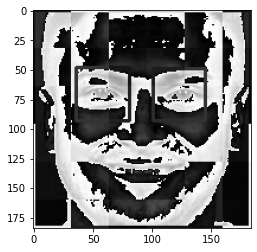

In [40]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

wavelet function gives us the edge of eye, lips and face shape which we will use as training data also with the raw image

## Load image, detect face and two eyes, then well save the cropped version of the image

In [41]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

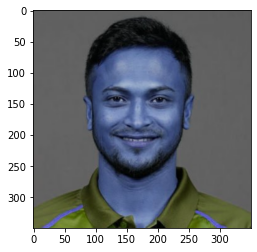

In [42]:
original_image = cv2.imread(main_path+'test_images/shakib1.jpg')
plt.imshow(original_image)

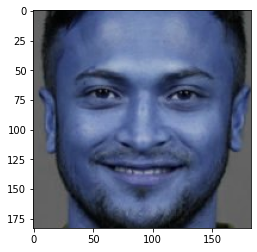

In [43]:
cropped_image = get_cropped_image_if_2_eyes(main_path+'test_images/shakib1.jpg')
plt.imshow(cropped_image)

we can see that bellow the image doesn't have two eyes visible, we won't get any cropped version of that image back from the function.

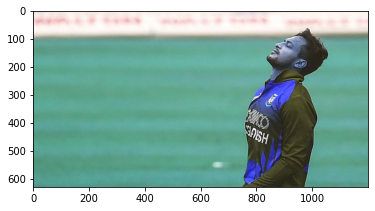

In [44]:
org_image_obstructed = cv2.imread(main_path + 'test_images/shakib2.jpg')
plt.imshow(org_image_obstructed)

In [45]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes(main_path + 'test_images/shakib2.jpg')
cropped_image_no_2_eyes

no cropped image is returened from above fucntion

In [46]:
path_to_data = main_path + "dataset/"
path_to_cr_data = main_path + "dataset/cropped/"

In [47]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [48]:
img_dirs

['/content/drive/MyDrive/Colab Notebooks/projects/dataset/roger_federar',
 '/content/drive/MyDrive/Colab Notebooks/projects/dataset/shakib_al_hasan',
 '/content/drive/MyDrive/Colab Notebooks/projects/dataset/leonel_messi',
 '/content/drive/MyDrive/Colab Notebooks/projects/dataset/maria_sharapova',
 '/content/drive/MyDrive/Colab Notebooks/projects/dataset/luis_hamilton']

Go through all images in dataset folder and create cropped images for all of the sport persons. There will be cropped folder inside dataset folder after running this code

In [49]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [50]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  /content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/roger_federar
Generating cropped images in folder:  /content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/shakib_al_hasan
Generating cropped images in folder:  /content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi
Generating cropped images in folder:  /content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/maria_sharapova
Generating cropped images in folder:  /content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/luis_hamilton


now we have the cropped face images of the sport persons which we will use to train and test the model

we are going to manually check all the cropped images to see if the persons are really the person we are looking for 

In [51]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'leonel_messi': ['/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi1.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi2.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi3.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi4.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi5.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi6.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi7.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi8.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leonel_messi9.png',
  '/content/drive/MyDrive/Colab Notebooks/projects/dataset/cropped/leonel_messi/leon

In [52]:
#assigning each players with numbers
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'leonel_messi': 2,
 'luis_hamilton': 4,
 'maria_sharapova': 3,
 'roger_federar': 0,
 'shakib_al_hasan': 1}

###image from the cropped dataset will be used for model training. we will input the raw image and also wavelet transformed image both to train the model


In [53]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])   

In [54]:
len(X[0])

4096

In [56]:
#resizing image to match the input parameters
32*32*3 + 32*32

4096

In [62]:
X[0]

array([[  0],
       [  0],
       [  0],
       ...,
       [ 47],
       [121],
       [220]], dtype=uint8)

In [61]:
y[0]

0

In [63]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(191, 4096)

##Training Model

In [64]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7708333333333334

In [66]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.67      0.75      0.71         8
           2       0.75      0.75      0.75         8
           3       0.81      0.94      0.87        18
           4       0.75      0.86      0.80         7

    accuracy                           0.77        48
   macro avg       0.80      0.72      0.71        48
weighted avg       0.79      0.77      0.75        48



###Using GridSearch to try out different models with different parameters to find the best find tuned parameters for the models

In [67]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [68]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [69]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.684975,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.474877,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.713054,{'logisticregression__C': 1}


In [70]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))])}

In [71]:
best_estimators['svm'].score(X_test,y_test)

0.75

In [72]:
best_estimators['random_forest'].score(X_test,y_test)

0.6041666666666666

In [73]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8333333333333334

looks like the logistic regression model gives the best accuracy

In [74]:
best_clf = best_estimators['logistic_regression']

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  1],
       [ 0,  1,  5,  1,  1],
       [ 0,  0,  1, 17,  0],
       [ 1,  1,  0,  1,  4]])

Text(69.0, 0.5, 'Truth')

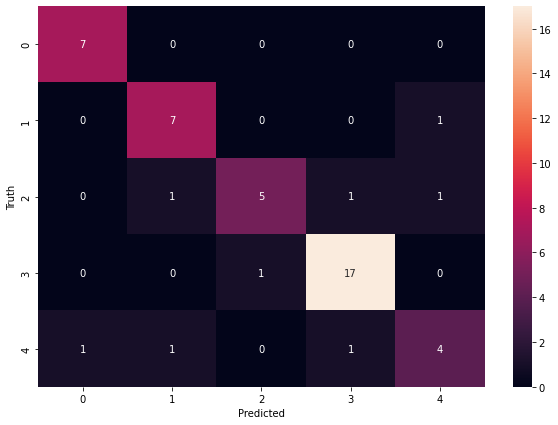

In [76]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [77]:
class_dict

{'leonel_messi': 2,
 'luis_hamilton': 4,
 'maria_sharapova': 3,
 'roger_federar': 0,
 'shakib_al_hasan': 1}

saving the best model weights

In [78]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

saving the class directory

In [79]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))